In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tqdm import tqdm

import optuna
from sklearn.metrics import f1_score, auc, roc_curve

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\HyeonJinLee\Documents\dev\Upstage_AI_LAB_ML_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./src/train.csv') as f:
    train = pd.read_csv(f)
with open('./src/test.csv') as f:
    test = pd.read_csv(f)

In [3]:
train.head(5)

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [4]:
train = train.drop(columns='user_id')
test = test.drop(columns = 'user_id')
train

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,22,29,14.727623,84.053558,18,16,64.966803,2,5,Low,Premium,1,1,1
9996,10,11,19.374054,45.464833,9,8,82.750244,3,3,Medium,Basic,2,7,1
9997,7,27,18.240978,127.302411,24,14,81.567839,3,5,High,Basic,1,6,1
9998,11,7,18.783800,5.297234,10,10,89.885656,4,5,Low,Basic,2,0,1


In [6]:
train.payment_pattern = train.payment_pattern.astype('object', copy = False)
test.payment_pattern = test.payment_pattern.astype('object')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              10000 non-null  int64  
 1   recent_login_time                  10000 non-null  int64  
 2   average_login_time                 10000 non-null  float64
 3   average_time_per_learning_session  10000 non-null  float64
 4   monthly_active_learning_days       10000 non-null  int64  
 5   total_completed_courses            10000 non-null  int64  
 6   recent_learning_achievement        10000 non-null  float64
 7   abandoned_learning_sessions        10000 non-null  int64  
 8   community_engagement_level         10000 non-null  int64  
 9   preferred_difficulty_level         10000 non-null  object 
 10  subscription_type                  10000 non-null  object 
 11  customer_inquiry_history           10000 non-null  int6

In [7]:
# train['average_time_per_learning_session_180+'] = train['average_time_per_learning_session'] >= 180
# train['average_time_per_learning_session_160_180'] = (train['average_time_per_learning_session'] >= 160) & (train['average_time_per_learning_session'] < 180)

In [8]:
cols = list(train.columns)                                                                      # 모든 feature 선택
cols.remove('target')
col = ['average_time_per_learning_session','recent_learning_achievement','average_login_time']  # 임의의 feature를 선택하기 위함
# col = ['average_time_per_learning_session','average_time_per_learning_session_180+','recent_learning_achievement','average_login_time']  # 임의의 feature를 선택하기 위함
# col = ['average_time_per_learning_session','average_time_per_learning_session_180+','average_time_per_learning_session_160_180','recent_learning_achievement','average_login_time']  # 임의의 feature를 선택하기 위함
X = train.loc[:,cols]
y = train.loc[:,'target']
X = pd.get_dummies(X)
scale_pos_weight = (y==0).sum()/(y==1).sum()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=39)

In [9]:
def optimizer1(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 100, 2500)
    learning_rate = trial.suggest_float('learning_rate',0.01, 0.45)
    num_leaves = trial.suggest_categorical('num_leaves',[255, 511,1023,2047,4095])
    colsample_bytree = trial.suggest_float('colsample_bytree',0.35,0.9)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,200)
    min_child_samples = trial.suggest_int('min_child_samples',5,50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_split_gain = trial.suggest_float('min_split_gain', 0.001, 0.05)

    model = LGBMClassifier(n_estimators = n_estimators,
                          learning_rate = learning_rate,
                          max_depth = max_depth,
                          colsample_bytree = colsample_bytree,
                          num_leaves= num_leaves,
                          min_child_samples= min_child_samples,
                          reg_lambda = reg_lambda,
                          min_split_gain= min_split_gain,
                          scale_pos_weight = scale_pos_weight,
                          random_state = 39,
                          objective = 'binary',
                          verbose  = -1)
    
    kf = StratifiedKFold(n_splits = K, random_state=39, shuffle=True)
    macrof1 = []
    for idx, (train_idx, val_idx) in enumerate(tqdm(kf.split(X,y), ascii = ' =')):
        X_train = X.iloc[train_idx,:]
        X_val = X.iloc[val_idx,:]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        

        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        macrof1.append(f1_score(y_val, prediction, average= 'macro'))
    
    return np.mean(macrof1)

In [30]:
K = 5
opt_func = partial(optimizer1, X = X, y = y, K = K)
study = optuna.create_study(direction = 'maximize')
study.optimize(opt_func, n_trials = 1024)

print(f"best score : {study.best_value:.4f}")
print(f"best params : {study.best_params}")

[I 2023-12-12 10:48:46,430] A new study created in memory with name: no-name-72041c43-cb20-43c6-b148-f9b1a47baf97
5it [00:02,  2.17it/s]
[I 2023-12-12 10:48:48,750] Trial 0 finished with value: 0.5097637861986384 and parameters: {'n_estimators': 141, 'learning_rate': 0.14771836315785122, 'num_leaves': 511, 'colsample_bytree': 0.8780316196935971, 'reg_lambda': 162.63778334068076, 'min_child_samples': 42, 'max_depth': 10, 'min_split_gain': 0.015632262334405775}. Best is trial 0 with value: 0.5097637861986384.
5it [00:08,  1.72s/it]
[I 2023-12-12 10:48:57,369] Trial 1 finished with value: 0.5088271795613851 and parameters: {'n_estimators': 1158, 'learning_rate': 0.3106966406662935, 'num_leaves': 255, 'colsample_bytree': 0.8985396352136041, 'reg_lambda': 100.14178658287375, 'min_child_samples': 15, 'max_depth': 8, 'min_split_gain': 0.016686164838529416}. Best is trial 0 with value: 0.5097637861986384.
5it [00:02,  1.91it/s]
[I 2023-12-12 10:49:00,004] Trial 2 finished with value: 0.5124266

best score : 0.5232
best params : {'n_estimators': 1394, 'learning_rate': 0.37643058149622016, 'num_leaves': 255, 'colsample_bytree': 0.40699818685195654, 'reg_lambda': 1.8956481455849996, 'min_child_samples': 50, 'max_depth': 11, 'min_split_gain': 0.03826358888408388}


In [31]:
print(f"feature : {list(X.columns)}")
print("")
print(f"best score : {study.best_value:.4f}")
print("")
print(f"fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1")
print("")
print(f"best params : {study.best_params}")

feature : ['subscription_duration', 'recent_login_time', 'average_login_time', 'average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'recent_learning_achievement', 'abandoned_learning_sessions', 'community_engagement_level', 'customer_inquiry_history', 'preferred_difficulty_level_High', 'preferred_difficulty_level_Low', 'preferred_difficulty_level_Medium', 'subscription_type_Basic', 'subscription_type_Premium', 'payment_pattern_0', 'payment_pattern_1', 'payment_pattern_2', 'payment_pattern_3', 'payment_pattern_4', 'payment_pattern_5', 'payment_pattern_6', 'payment_pattern_7']

best score : 0.5232

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 1394, 'learning_rate': 0.37643058149622016, 'num_leaves': 255, 'colsample_bytree': 0.40699818685195654, 'reg_lambda': 1.8956481455849996, 'min_child_samples': 50, 'max_depth': 11, 'min_split_gain': 0.0382635888840

### study 1

best : 0.5228

best params : {'n_estimators': 1790, 'learning_rate': 0.2931348491046597, 'num_leaves': 1023, 'colsample_bytree': 0.6101546050708754, 'reg_lambda': 10.09474405737206, 'min_child_samples': 28}

### study 2 (fix learning rate) **BEST ONE**

best score : 0.5251

best params : {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 511, 'colsample_bytree': 0.5000263102652682, 'reg_lambda': 10.196712114510644, 'min_child_samples': 21}

### study 3 (fix learning rate, n_estimators)

best score : 0.5239

best params : {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 2047, 'colsample_bytree': 0.5181718302148206, 'reg_lambda': 5.1278966572882805, 'min_child_samples': 24}

### study 4 (only learning rate & n_estimators)

best score : 0.5232

best params : {'n_estimators': 1604, 'learning_rate': 0.2854734948947413}

### study 5 

feature : ['average_time_per_learning_session','recent_learning_achievement','average_login_time']

fixed_params = {'verbose': -1, 'random_state' : 39, 'scale_pos_weight' : (y==0).sum()/(y==1).sum(), 'objective' : 'binary'}

best score : 0.5239

best params : {'n_estimators': 1984, 'learning_rate': 0.4085149969880825, 'num_leaves': 4095, 'colsample_bytree': 0.7494160070231346, 'reg_lambda': 142.96440871842478, 'min_child_samples': 20, 'max_depth': 14}

hyperparams imp : n_estimators > learning_rate > reg_lambda > comsample_bytree > max_depth > min_child_samples > num_leaves (<0.01)

### study 6 : 

feature : ['average_time_per_learning_session','recent_learning_achievement','average_login_time']

best score : 0.5260728635356032

fixed_params = {'verbose': -1, 'random_state' : 39, 'scale_pos_weight' : (y==0).sum()/(y==1).sum(), 'objective' : 'binary'}

{'n_estimators': 1812, 'learning_rate': 0.31735941855710437, 'num_leaves': 4095, 'colsample_bytree': 0.7620983072850699, 'reg_lambda': 189.76951762262595, 'min_child_samples': 18, 'max_depth': 10}

### study 7 : 

feature : ['average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'preferred_difficulty_level']

best score : 0.5343

fixed params : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 730, 'learning_rate': 0.21168324704287816, 'num_leaves': 4095, 'colsample_bytree': 0.7248171482885882, 'reg_lambda': 14.045778373182287, 'min_child_samples': 36, 'max_depth': 15}

### study 8 : trial 50

feature : ['average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5293

fixed_feature :  scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 879, 'learning_rate': 0.03094396780585361, 'num_leaves': 511, 'colsample_bytree': 0.58105140209972, 'reg_lambda': 1.9063548714135379, 'min_child_samples': 8, 'max_depth': 15, 'min_split_gain': 0.05391711853832056}

### study 9 :

feature : ['average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5208

fixed_feature : 

best params : {'n_estimators': 764, 'learning_rate': 0.11897262039240156, 'num_leaves': 1023, 'colsample_bytree': 0.8179184902254071, 'reg_lambda': 164.46190019907746, 'min_child_samples': 25, 'max_depth': 14, 'min_split_gain': 0.015713576607704918}

### study 10 :

feature : ['average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5277

fixed_feature : 

best params : {'n_estimators': 1805, 'learning_rate': 0.07449656929404308, 'num_leaves': 255, 'colsample_bytree': 0.7162609716127136, 'reg_lambda': 0.8656800146905494, 'min_child_samples': 7, 'max_depth': 8, 'min_split_gain': 0.02930837057650732}

### study 11 : make new Feature 'average_time_per_learning_session_over_160'

feature : ['average_time_per_learning_session_over_160', 'recent_learning_achievement', 'average_login_time']

best score : 0.5281

fixed_feature : 

best params : {'n_estimators': 1971, 'learning_rate': 0.34798269140455584, 'num_leaves': 255, 'colsample_bytree': 0.8051943795866303, 'reg_lambda': 103.36997124920711, 'min_child_samples': 6, 'max_depth': 12, 'min_split_gain': 0.005869404717520133}

### study 12 : 

feature : ['average_time_per_learning_session', 'average_time_per_learning_session_over_160', 'monthly_active_learning_days', 'total_completed_courses', 'preferred_difficulty_level_High', 'preferred_difficulty_level_Low', 'preferred_difficulty_level_Medium']

best score : 0.5293

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 1584, 'learning_rate': 0.059621699095461986, 'num_leaves': 1023, 'colsample_bytree': 0.8038729297107452, 'reg_lambda': 21.275819199800978, 'min_child_samples': 19, 'max_depth': 10, 'min_split_gain': 0.0024983287132747008}

### study 13 : not submitted yet

feature : ['average_time_per_learning_session_over_160', 'average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5252

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 2000, 'learning_rate': 0.2701238200790122, 'num_leaves': 1023, 'colsample_bytree': 0.653879684071935, 'reg_lambda': 8.795492416808628, 'min_child_samples': 17, 'max_depth': 10, 'min_split_gain': 0.04610277650831613}

### study 14 :

feature : ['average_time_per_learning_session_over_160', 'average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5243

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 1035, 'learning_rate': 0.3942187948821839, 'num_leaves': 2047, 'colsample_bytree': 0.8729349266800058, 'reg_lambda': 33.0848670909797, 'min_child_samples': 9, 'max_depth': 11, 'min_split_gain': 0.04430081438481328}

### last

feature : ['average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5261

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 2221, 
                'learning_rate': 0.4258592315024251, 'num_leaves': 4095, 'colsample_bytree': 0.7535574287580454, 'reg_lambda': 185.6146857569011, 'min_child_samples': 20, 'max_depth': 9, 'min_split_gain': 0.0037548335166726647}


In [ ]:
optuna.visualization.plot_param_importances(study)

In [13]:
best_params = study.best_params
# best_params = {'n_estimators': 2221, 
#                'learning_rate': 0.4258592315024251, 
#                'num_leaves': 4095, 
#                'colsample_bytree': 0.7535574287580454,
#                'reg_lambda': 185.6146857569011, 
#                'min_child_samples': 20, 
#                'max_depth': 9, 
#                'min_split_gain': 0.0037548335166726647}

# best_params = {'n_estimators': 2495, 
#                'learning_rate': 0.21939722816397986, 
#                'num_leaves': 4095, 
#                'colsample_bytree': 0.5950225378851886, 
#                'reg_lambda': 62.21738458660579, 
#                'min_child_samples': 19, 
#                'min_split_gain': 0.0012418065532667968}


In [14]:

model1 = XGBClassifier(n_estimators= 1729,
                      learning_rate= 0.26962375010754236,
                      max_depth= 6,
                      colsample_bynode= 0.6800192128540902,
                      reg_lambda= 153.79087269756306)

model2 = LGBMClassifier(**best_params,
                        scale_pos_weight = scale_pos_weight,
                        random_state=39,
                        objective = 'binary',
                        importance_type='gain',
                        verbose = -1)
model3 = LGBMClassifier(random_state=39,
                        objective= 'binary',
                        verbose = -1)

c:\Users\HyeonJinLee\Documents\dev\Upstage_AI_LAB_ML_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\HyeonJinLee\Documents\dev\Upstage_AI_LAB_ML_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\HyeonJinLee\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HyeonJinLee\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, c

macro f1 score : 0.4601941263941346


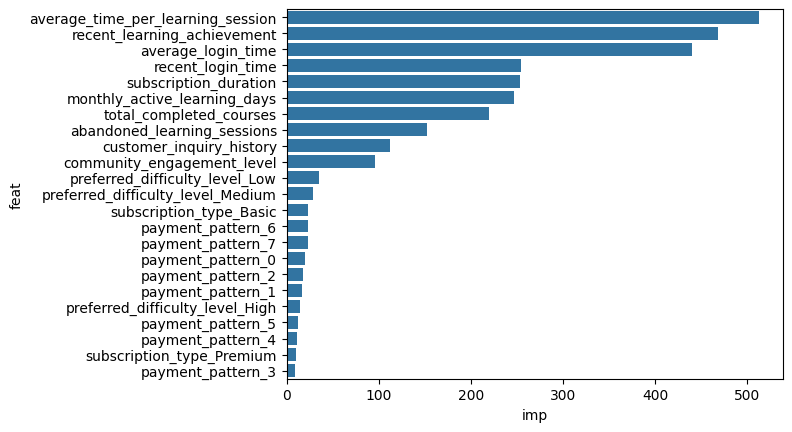

In [15]:
best_feature = None
best_score = 0
col = ['average_time_per_learning_session','recent_learning_achievement']  # 임의의 feature를 선택하기 위함

X1 = train.loc[:, cols]
y1 = train.loc[:,'target']
X1 = pd.get_dummies(X1)
K = 5
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=39)
macrof1 = []
feat_imp = []

for idx, (train_idx, val_idx) in enumerate(kf.split(X1, y1)):
    X_train = X1.iloc[train_idx,:]
    X_val = X1.iloc[val_idx,:]
    y_train = y1.iloc[train_idx]
    y_val = y1.iloc[val_idx]


    model3.fit(X_train, y_train)
    prediction = model3.predict(X_val)
    macrof1.append(f1_score(y_val, prediction, average = 'macro'))
    feat_imp.append(model3.feature_importances_)

print(f"macro f1 score : {np.mean(macrof1)}")

tmp = pd.DataFrame({'feat': X_train.columns, 'imp' : sum(feat_imp)/K}).sort_values(by = 'imp', ascending=False)
sns.barplot(y = tmp.feat, x =  tmp.imp)
plt.show()

In [25]:
with open('./src/sample_submission.csv') as f:
    submission = pd.read_csv(f)
# best_params = {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 511, 'colsample_bytree': 0.5000263102652682, 'reg_lambda': 10.196712114510644, 'min_child_samples': 21}
model = LGBMClassifier(**best_params,
                       objective = 'binary',
                       scale_pos_weight = scale_pos_weight,
                       random_state = 39,
                       verbose = -1)
# test['average_time_per_learning_session_180+'] = test['average_time_per_learning_session'] >= 180
# test['average_time_per_learning_session_160_180'] = (test['average_time_per_learning_session'] >= 160) & (test['average_time_per_learning_session'] < 180)
model.fit(X, y)
pred = model.predict(pd.get_dummies(test[['average_time_per_learning_session','recent_learning_achievement','average_login_time']]))
submission.target = pred
submission.to_csv('./src/submission.csv', index=False)